<a href="https://colab.research.google.com/github/JCaballerot/Deep_learning_program/blob/main/Topicos_avanzados/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1 align="center"><font size="5">CIFAR10</font></h1>


<center>
  <img src="https://symjax.readthedocs.io/en/latest/_images/sphx_glr_plot_cifar10_001.svg" width="800" height="300">
</center>


Este laboratorio se enfoca en la construcción, entrenamiento y optimización de un modelo de red neuronal convolucional (CNN) para clasificar imágenes del conjunto de datos CIFAR10, que consiste en 60,000 imágenes a color de 32x32 distribuidas en 10 clases diferentes.

### 1. Instalación de dependencias


Primero, instalamos scikeras, que es una interfaz de Scikit-learn para Keras, permitiéndonos usar herramientas de Scikit-learn como GridSearchCV para optimizar nuestros modelos de Keras.

In [1]:
%%capture
!pip3 install scikeras

---

### 2. Importación de librerías necesarias

Aquí importamos todas las librerías necesarias para nuestro laboratorio, incluyendo TensorFlow, Keras para la construcción del modelo, y Scikit-learn para la optimización de hiperparámetros.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier


---

### 3. Definición del modelo


En esta sección, definimos la arquitectura de nuestra red neuronal convolucional (CNN), especificando capas convolucionales, capas de pooling, y capas densas para la clasificación. También configuramos dinámicamente el optimizador, la tasa de aprendizaje y la función de pérdida.

In [3]:


def create_model(learning_rate=0.01, optimizer='adam', loss='sparse_categorical_crossentropy', l1_reg=0.01):
    model = Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Dropout(0.25),  # Agregar Dropout después de la capa de MaxPooling
        Flatten(),
        Dense(64, activation='relu', kernel_regularizer=l1(l1_reg)),  # Aplicar regularización L1 aquí
        Dropout(0.5),  # Agregar Dropout antes de la capa final
        Dense(10, activation='softmax', kernel_regularizer=l1(l1_reg))  # Aplicar regularización L1 aquí
    ])

    optimizer_choices = {
        'adam': Adam(learning_rate=learning_rate),
        'sgd': keras.optimizers.SGD(learning_rate=learning_rate),
        'rmsprop': keras.optimizers.RMSprop(learning_rate=learning_rate)
    }

    model.compile(optimizer=optimizer_choices[optimizer],
                  loss=loss,
                  metrics=['accuracy'])
    return model


### 4. Preprocesamiento de datos


Cargamos y preprocesamos el conjunto de datos CIFAR10, normalizando las imágenes y convirtiendo las etiquetas a formato one-hot para su uso con la función de pérdida categorical_crossentropy.

In [4]:
from tensorflow.keras.utils import to_categorical

In [5]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

170498071/170498071 [==============================] - 11s 0us/step


In [11]:
x_train.shape

(50000, 32, 32, 3)

In [6]:
# Muestrear 2000 datos aleatoriamente de cada conjunto (entrenamiento y prueba)
indices_train = np.random.choice(range(x_train.shape[0]), size = 10000, replace=False)
indices_test = np.random.choice(range(x_test.shape[0]), size = 10000, replace=False)

x_train_sampled = x_train[indices_train]
y_train_sampled = y_train[indices_train]

x_test_sampled = x_test[indices_test]
y_test_sampled = y_test[indices_test]

In [7]:

# Normalizar los datos
x_train_sampled, x_test_sampled = x_train_sampled / 255.0, x_test_sampled / 255.0

# Para usar 'categorical_crossentropy', necesitamos etiquetas en formato one-hot
y_train_one_hot = to_categorical(y_train_sampled, 10)
y_test_one_hot = to_categorical(y_test_sampled, 10)

### 5. Configuración de Gridsearch


Establecemos una grilla de hiperparámetros para explorar diferentes configuraciones de tasa de aprendizaje, tamaño de lote, optimizadores y funciones de pérdida, y preparamos nuestro modelo para la optimización.

In [8]:
param_grid = {
    'model__learning_rate': [0.001, 0.01],
    'batch_size': [64, 128],
    'model__optimizer': ['adam', 'sgd', 'rmsprop'],  # optimizador
    'model__loss': ['sparse_categorical_crossentropy', 'categorical_crossentropy'],  # función de pérdida
    'model__l1_reg': [0.001, 0.01, 0.1]  # Nuevos valores de regularización L1 para probar
}


### 6. Ejecución de la búsqueda de hiperparámetros y resultados


Finalmente, ejecutamos la búsqueda de hiperparámetros utilizando GridSearchCV, entrenando el modelo con diferentes configuraciones y evaluando su rendimiento. Los mejores parámetros se muestran al final, junto con el rendimiento de todas las configuraciones probadas.

In [9]:

model = KerasClassifier(build_fn = create_model, epochs = 10, verbose=1)  # Ajusta epochs según necesidad
grid = GridSearchCV(estimator = model, param_grid = param_grid, n_jobs = 1, cv = 3, return_train_score = True, verbose = 2)


In [10]:
# Usa y_train_one_hot si eliges 'categorical_crossentropy', y_train para 'sparse_categorical_crossentropy'
grid_result = grid.fit(x_train_sampled, y_train_sampled)


Fitting 3 folds for each of 72 candidates, totalling 216 fits


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 4s 115ms/step - loss: 8.7981 - accuracy: 0.1100
Epoch 2/10
4/4 [==============================] - 0s 80ms/step - loss: 7.6332 - accuracy: 0.1750
Epoch 3/10
4/4 [==============================] - 0s 68ms/step - loss: 6.6036 - accuracy: 0.2000
Epoch 4/10
4/4 [==============================] - 0s 97ms/step - loss: 5.6938 - accuracy: 0.1900
Epoch 5/10
4/4 [==============================] - 0s 75ms/step - loss: 4.9799 - accuracy: 0.1900
Epoch 6/10
4/4 [==============================] - 0s 69ms/step - loss: 4.3961 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 70ms/step - loss: 3.9651 - accuracy: 0.2250
Epoch 8/10
4/4 [==============================] - 0s 72ms/step - loss: 3.7397 - accuracy: 0.1600
Epoch 9/10
4/4 [==============================] - 0s 76ms/step - loss: 3.5173 - accuracy: 0.2200
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 2s 42ms/step - loss: 8.7510 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 7.5356 - accuracy: 0.1700
Epoch 3/10
4/4 [==============================] - 0s 43ms/step - loss: 6.4414 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 5.5572 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 4.8180 - accuracy: 0.1550
Epoch 6/10
4/4 [==============================] - 0s 45ms/step - loss: 4.2582 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 55ms/step - loss: 3.8722 - accuracy: 0.1500
Epoch 8/10
4/4 [==============================] - 0s 60ms/step - loss: 3.6335 - accuracy: 0.1250
Epoch 9/10
4/4 [==============================] - 0s 63ms/step - loss: 3.4605 - accuracy: 0.2100
Epoch 10/10
4/4 [==============================] - 0s 16ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 42ms/step - loss: 8.8526 - accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 40ms/step - loss: 7.7542 - accuracy: 0.1650
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 6.7227 - accuracy: 0.1400
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 5.8663 - accuracy: 0.1850
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 5.2195 - accuracy: 0.1550
Epoch 6/10
4/4 [==============================] - 0s 40ms/step - loss: 4.6426 - accuracy: 0.1800
Epoch 7/10
4/4 [==============================] - 0s 41ms/step - loss: 4.2253 - accuracy: 0.1600
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 3.9671 - accuracy: 0.2050
Epoch 9/10
4/4 [==============================] - 0s 37ms/step - loss: 3.7559 - accuracy: 0.2150
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_ra

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 38ms/step - loss: 9.0376 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 45ms/step - loss: 9.0220 - accuracy: 0.1300
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 9.0329 - accuracy: 0.1400
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 9.0314 - accuracy: 0.1050
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 9.0170 - accuracy: 0.1250
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 9.0387 - accuracy: 0.1000
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 9.0064 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 9.0176 - accuracy: 0.1000
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 8.9940 - accuracy: 0.1300
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_ra

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 9.0429 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 9.0528 - accuracy: 0.1250
Epoch 3/10
4/4 [==============================] - 0s 43ms/step - loss: 9.0094 - accuracy: 0.1350
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 9.0314 - accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 9.0117 - accuracy: 0.1300
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 8.9943 - accuracy: 0.1650
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 9.0170 - accuracy: 0.1600
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 9.0077 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 8.9944 - accuracy: 0.1350
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 46ms/step - loss: 9.0572 - accuracy: 0.0650
Epoch 2/10
4/4 [==============================] - 0s 54ms/step - loss: 9.0397 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 52ms/step - loss: 9.0303 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 56ms/step - loss: 9.0199 - accuracy: 0.1450
Epoch 5/10
4/4 [==============================] - 0s 54ms/step - loss: 9.0501 - accuracy: 0.0750
Epoch 6/10
4/4 [==============================] - 0s 57ms/step - loss: 9.0582 - accuracy: 0.0900
Epoch 7/10
4/4 [==============================] - 0s 55ms/step - loss: 9.0299 - accuracy: 0.1200
Epoch 8/10
4/4 [==============================] - 0s 53ms/step - loss: 9.0019 - accuracy: 0.1000
Epoch 9/10
4/4 [==============================] - 0s 61ms/step - loss: 8.9946 - accuracy: 0.1050
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 8.8789 - accuracy: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 6.5881 - accuracy: 0.1550
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 5.3849 - accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 4.5683 - accuracy: 0.1550
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 3.9427 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 3.5781 - accuracy: 0.1650
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 3.3964 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 3.2009 - accuracy: 0.2200
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 3.1305 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 36ms/step - loss: 8.6988 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 33ms/step - loss: 6.4910 - accuracy: 0.1400
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 5.2287 - accuracy: 0.1400
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 4.3486 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 3.7938 - accuracy: 0.1250
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 3.4008 - accuracy: 0.2000
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 3.2321 - accuracy: 0.1800
Epoch 8/10
4/4 [==============================] - 0s 39ms/step - loss: 3.1455 - accuracy: 0.2050
Epoch 9/10
4/4 [==============================] - 0s 33ms/step - loss: 2.9848 - accuracy: 0.2200
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 8.4457 - accuracy: 0.1350
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 6.4368 - accuracy: 0.1650
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 5.2050 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 32ms/step - loss: 4.3298 - accuracy: 0.1750
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 3.6935 - accuracy: 0.1950
Epoch 6/10
4/4 [==============================] - 0s 40ms/step - loss: 3.3253 - accuracy: 0.2100
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 3.1216 - accuracy: 0.2350
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 3.0042 - accuracy: 0.2050
Epoch 9/10
4/4 [==============================] - 0s 59ms/step - loss: 2.9116 - accuracy: 0.2050
Epoch 10/10
4/4 [==============================] - 0s 16ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 36ms/step - loss: 10.4843 - accuracy: 0.1100
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 7.2227 - accuracy: 0.1150
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 6.5017 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 5.8988 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 5.3136 - accuracy: 0.1200
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 4.8025 - accuracy: 0.1350
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 4.3477 - accuracy: 0.1300
Epoch 8/10
4/4 [==============================] - 0s 32ms/step - loss: 4.0269 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 40ms/step - loss: 3.7382 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 8.4142 - accuracy: 0.1350
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 6.5817 - accuracy: 0.0950
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 5.7956 - accuracy: 0.1050
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 5.2432 - accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 4.7166 - accuracy: 0.0950
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 4.2723 - accuracy: 0.1300
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 3.8931 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 3.6383 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 33ms/step - loss: 3.4104 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 11.4979 - accuracy: 0.1250
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 7.0312 - accuracy: 0.0950
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 6.2765 - accuracy: 0.1150
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 5.7537 - accuracy: 0.1000
Epoch 5/10
4/4 [==============================] - 0s 56ms/step - loss: 5.3041 - accuracy: 0.1550
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 4.8309 - accuracy: 0.1200
Epoch 7/10
4/4 [==============================] - 0s 54ms/step - loss: 4.4770 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 57ms/step - loss: 4.1691 - accuracy: 0.1700
Epoch 9/10
4/4 [==============================] - 0s 57ms/step - loss: 3.8602 - accuracy: 0.1500
Epoch 10/10
4/4 [==============================] - 0s 22ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 34ms/step - loss: 9.0757 - accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 9.0214 - accuracy: 0.1150
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 8.9948 - accuracy: 0.1150
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 8.9422 - accuracy: 0.1250
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 8.9237 - accuracy: 0.1600
Epoch 6/10
4/4 [==============================] - 0s 41ms/step - loss: 8.9291 - accuracy: 0.1350
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 8.8582 - accuracy: 0.1650
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 8.8470 - accuracy: 0.1800
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 8.8575 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 36ms/step - loss: 9.0383 - accuracy: 0.1400
Epoch 2/10
4/4 [==============================] - 0s 31ms/step - loss: 9.0025 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 8.9765 - accuracy: 0.0900
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 8.9442 - accuracy: 0.0950
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 8.9375 - accuracy: 0.1150
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 8.9059 - accuracy: 0.1300
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 8.8686 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 8.8721 - accuracy: 0.1300
Epoch 9/10
4/4 [==============================] - 0s 32ms/step - loss: 8.8320 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 33ms/step - loss: 9.0331 - accuracy: 0.0550
Epoch 2/10
4/4 [==============================] - 0s 33ms/step - loss: 8.9911 - accuracy: 0.1050
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 8.9733 - accuracy: 0.0950
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 8.9379 - accuracy: 0.1300
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 8.9242 - accuracy: 0.1100
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 8.9064 - accuracy: 0.1100
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 8.8639 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 8.8567 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 33ms/step - loss: 8.8246 - accuracy: 0.1850
Epoch 10/10
4/4 [==============================] - 0s 20ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 35ms/step - loss: 21.5184 - accuracy: 0.1350
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 6.9227 - accuracy: 0.0850
Epoch 3/10
4/4 [==============================] - 0s 32ms/step - loss: 5.7089 - accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 5.1698 - accuracy: 0.1300
Epoch 5/10
4/4 [==============================] - 0s 33ms/step - loss: 4.8982 - accuracy: 0.1050
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 4.7065 - accuracy: 0.1100
Epoch 7/10
4/4 [==============================] - 0s 42ms/step - loss: 4.5711 - accuracy: 0.1650
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 4.5031 - accuracy: 0.1800
Epoch 9/10
4/4 [==============================] - 0s 33ms/step - loss: 4.4823 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 22.2138 - accuracy: 0.0850
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 7.5697 - accuracy: 0.1100
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 6.1985 - accuracy: 0.1350
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 5.4810 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 5.0600 - accuracy: 0.1100
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 4.7991 - accuracy: 0.1550
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 4.6249 - accuracy: 0.1700
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 4.5165 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 4.4540 - accuracy: 0.1550
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 34ms/step - loss: 18.4478 - accuracy: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 32ms/step - loss: 7.6581 - accuracy: 0.1350
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 6.1888 - accuracy: 0.1300
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 5.4286 - accuracy: 0.1150
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 5.0049 - accuracy: 0.1300
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 4.7247 - accuracy: 0.1150
Epoch 7/10
4/4 [==============================] - 0s 33ms/step - loss: 4.5603 - accuracy: 0.1300
Epoch 8/10
4/4 [==============================] - 0s 32ms/step - loss: 4.4792 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 4.5001 - accuracy: 0.1600
Epoch 10/10
4/4 [==============================] - 0s 15ms/step
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.5s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 64.9581 - accuracy: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 49.6238 - accuracy: 0.1350
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 37.0310 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 44ms/step - loss: 26.8428 - accuracy: 0.1750
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 18.9032 - accuracy: 0.1750
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 13.2378 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 9.7509 - accuracy: 0.1650
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 8.4743 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 41ms/step - loss: 7.7756 - accuracy: 0.1750
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 33ms/step - loss: 64.7845 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 49.2803 - accuracy: 0.0900
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 36.4980 - accuracy: 0.0950
Epoch 4/10
4/4 [==============================] - 0s 41ms/step - loss: 26.1535 - accuracy: 0.1400
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 18.2568 - accuracy: 0.1100
Epoch 6/10
4/4 [==============================] - 0s 38ms/step - loss: 12.7081 - accuracy: 0.1150
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 9.4382 - accuracy: 0.1700
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 8.4344 - accuracy: 0.1300
Epoch 9/10
4/4 [==============================] - 0s 37ms/step - loss: 7.7886 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 64.7572 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 49.2850 - accuracy: 0.1300
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 36.5500 - accuracy: 0.1550
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 26.2656 - accuracy: 0.1150
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 18.3442 - accuracy: 0.1500
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 12.7421 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 52ms/step - loss: 9.4507 - accuracy: 0.2000
Epoch 8/10
4/4 [==============================] - 0s 55ms/step - loss: 8.3822 - accuracy: 0.1650
Epoch 9/10
4/4 [==============================] - 0s 65ms/step - loss: 7.7051 - accuracy: 0.1550
Epoch 10/10
4/4 [==============================] - 0s 21ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 32ms/step - loss: 69.4007 - accuracy: 0.1250
Epoch 2/10
4/4 [==============================] - 0s 32ms/step - loss: 69.2244 - accuracy: 0.1050
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 69.0191 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 68.8761 - accuracy: 0.0950
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 68.6559 - accuracy: 0.0900
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 68.4655 - accuracy: 0.1000
Epoch 7/10
4/4 [==============================] - 0s 31ms/step - loss: 68.2921 - accuracy: 0.0850
Epoch 8/10
4/4 [==============================] - 0s 33ms/step - loss: 68.1039 - accuracy: 0.1050
Epoch 9/10
4/4 [==============================] - 0s 33ms/step - loss: 67.9302 - accuracy: 0.1000
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lea

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 33ms/step - loss: 69.4862 - accuracy: 0.1050
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 69.2608 - accuracy: 0.0700
Epoch 3/10
4/4 [==============================] - 0s 33ms/step - loss: 69.0539 - accuracy: 0.1150
Epoch 4/10
4/4 [==============================] - 0s 33ms/step - loss: 68.8719 - accuracy: 0.0950
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 68.6720 - accuracy: 0.0900
Epoch 6/10
4/4 [==============================] - 0s 32ms/step - loss: 68.5160 - accuracy: 0.0750
Epoch 7/10
4/4 [==============================] - 0s 32ms/step - loss: 68.3307 - accuracy: 0.0750
Epoch 8/10
4/4 [==============================] - 0s 33ms/step - loss: 68.1070 - accuracy: 0.0750
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 67.9413 - accuracy: 0.0900
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 69.4550 - accuracy: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 33ms/step - loss: 69.2762 - accuracy: 0.1050
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 69.1111 - accuracy: 0.1100
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 68.8923 - accuracy: 0.1050
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 68.7036 - accuracy: 0.0750
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 68.5027 - accuracy: 0.1650
Epoch 7/10
4/4 [==============================] - 0s 41ms/step - loss: 68.3471 - accuracy: 0.0850
Epoch 8/10
4/4 [==============================] - 0s 33ms/step - loss: 68.1261 - accuracy: 0.1500
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 67.9698 - accuracy: 0.0950
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 2s 58ms/step - loss: 57.5618 - accuracy: 0.1100
Epoch 2/10
4/4 [==============================] - 0s 59ms/step - loss: 32.2181 - accuracy: 0.0850
Epoch 3/10
4/4 [==============================] - 0s 56ms/step - loss: 19.1375 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 56ms/step - loss: 11.3947 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 57ms/step - loss: 7.2506 - accuracy: 0.1200
Epoch 6/10
4/4 [==============================] - 0s 59ms/step - loss: 5.8802 - accuracy: 0.1300
Epoch 7/10
4/4 [==============================] - 0s 62ms/step - loss: 5.5414 - accuracy: 0.1300
Epoch 8/10
4/4 [==============================] - 0s 60ms/step - loss: 5.3901 - accuracy: 0.1300
Epoch 9/10
4/4 [==============================] - 0s 55ms/step - loss: 5.3369 - accuracy: 0.1250
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 37ms/step - loss: 57.9981 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 32.4132 - accuracy: 0.1550
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 19.4432 - accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - 0s 43ms/step - loss: 11.6551 - accuracy: 0.0950
Epoch 5/10
4/4 [==============================] - 0s 41ms/step - loss: 7.4485 - accuracy: 0.1100
Epoch 6/10
4/4 [==============================] - 0s 38ms/step - loss: 6.0359 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 45ms/step - loss: 5.7055 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 42ms/step - loss: 5.5725 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 45ms/step - loss: 5.4514 - accuracy: 0.1550
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 41ms/step - loss: 57.4721 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 45ms/step - loss: 31.6912 - accuracy: 0.0900
Epoch 3/10
4/4 [==============================] - 0s 40ms/step - loss: 18.6377 - accuracy: 0.1150
Epoch 4/10
4/4 [==============================] - 0s 43ms/step - loss: 10.8811 - accuracy: 0.1600
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 6.8689 - accuracy: 0.1250
Epoch 6/10
4/4 [==============================] - 0s 45ms/step - loss: 5.7303 - accuracy: 0.1300
Epoch 7/10
4/4 [==============================] - 0s 41ms/step - loss: 5.5268 - accuracy: 0.1150
Epoch 8/10
4/4 [==============================] - 0s 44ms/step - loss: 5.4381 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 39ms/step - loss: 5.3916 - accuracy: 0.1650
Epoch 10/10
4/4 [==============================] - 0s 13ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 2s 39ms/step - loss: 45.6564 - accuracy: 0.1100
Epoch 2/10
4/4 [==============================] - 0s 42ms/step - loss: 28.8744 - accuracy: 0.1050
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 18.9665 - accuracy: 0.1350
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 16.2606 - accuracy: 0.1300
Epoch 5/10
4/4 [==============================] - 0s 44ms/step - loss: 13.8443 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 12.3073 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 10.7186 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 10.2150 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 9.3704 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lear

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 43ms/step - loss: 45.9000 - accuracy: 0.1400
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 29.7893 - accuracy: 0.1400
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 19.6086 - accuracy: 0.1100
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 16.6221 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 14.1142 - accuracy: 0.1000
Epoch 6/10
4/4 [==============================] - 0s 40ms/step - loss: 12.4681 - accuracy: 0.1050
Epoch 7/10
4/4 [==============================] - 0s 39ms/step - loss: 10.8931 - accuracy: 0.1150
Epoch 8/10
4/4 [==============================] - 0s 40ms/step - loss: 10.3104 - accuracy: 0.1350
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 9.4733 - accuracy: 0.1200
Epoch 10/10
4/4 [==============================] - 0s 16ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 43ms/step - loss: 45.0401 - accuracy: 0.1250
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 28.9222 - accuracy: 0.0850
Epoch 3/10
4/4 [==============================] - 0s 41ms/step - loss: 18.8662 - accuracy: 0.0900
Epoch 4/10
4/4 [==============================] - 0s 40ms/step - loss: 16.2121 - accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 0s 42ms/step - loss: 13.8048 - accuracy: 0.1300
Epoch 6/10
4/4 [==============================] - 0s 44ms/step - loss: 12.2651 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 10.7495 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 41ms/step - loss: 10.2198 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 45ms/step - loss: 9.4136 - accuracy: 0.1350
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 2s 59ms/step - loss: 68.9361 - accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 58ms/step - loss: 67.0546 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 58ms/step - loss: 65.2239 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 53ms/step - loss: 63.4723 - accuracy: 0.1450
Epoch 5/10
4/4 [==============================] - 0s 37ms/step - loss: 61.7051 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 59.9865 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 58.3052 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 56.6137 - accuracy: 0.1700
Epoch 9/10
4/4 [==============================] - 0s 35ms/step - loss: 54.9751 - accuracy: 0.1800
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lea

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 69.0548 - accuracy: 0.0750
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 67.2229 - accuracy: 0.0850
Epoch 3/10
4/4 [==============================] - 0s 40ms/step - loss: 65.3610 - accuracy: 0.1350
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 63.5825 - accuracy: 0.1050
Epoch 5/10
4/4 [==============================] - 0s 37ms/step - loss: 61.8374 - accuracy: 0.1400
Epoch 6/10
4/4 [==============================] - 0s 33ms/step - loss: 60.1219 - accuracy: 0.1400
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 58.4261 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 56.7532 - accuracy: 0.1100
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 55.0937 - accuracy: 0.0900
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 37ms/step - loss: 69.0285 - accuracy: 0.0700
Epoch 2/10
4/4 [==============================] - 0s 34ms/step - loss: 67.1280 - accuracy: 0.1500
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 65.3606 - accuracy: 0.1000
Epoch 4/10
4/4 [==============================] - 0s 40ms/step - loss: 63.5943 - accuracy: 0.1150
Epoch 5/10
4/4 [==============================] - 0s 34ms/step - loss: 61.8190 - accuracy: 0.1250
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 60.0626 - accuracy: 0.1400
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 58.3574 - accuracy: 0.1550
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 56.7172 - accuracy: 0.1500
Epoch 9/10
4/4 [==============================] - 0s 35ms/step - loss: 55.0583 - accuracy: 0.1700
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lea

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 37ms/step - loss: 84.0178 - accuracy: 0.0650
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 41.7407 - accuracy: 0.1250
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 30.5417 - accuracy: 0.0850
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 26.8625 - accuracy: 0.1250
Epoch 5/10
4/4 [==============================] - 0s 32ms/step - loss: 25.4477 - accuracy: 0.1400
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 24.8607 - accuracy: 0.1400
Epoch 7/10
4/4 [==============================] - 0s 47ms/step - loss: 24.6106 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 51ms/step - loss: 24.5013 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 55ms/step - loss: 24.4429 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 15ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lea

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 37ms/step - loss: 78.8394 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 41.9469 - accuracy: 0.0750
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 30.1957 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 26.6958 - accuracy: 0.1450
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 25.4207 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 24.9169 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 24.6811 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 24.5734 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 41ms/step - loss: 24.5112 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__lea

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 36ms/step - loss: 70.5287 - accuracy: 0.0800
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 40.4804 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 29.6818 - accuracy: 0.1100
Epoch 4/10
4/4 [==============================] - 0s 38ms/step - loss: 26.9707 - accuracy: 0.1000
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 25.8136 - accuracy: 0.1200
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 25.2021 - accuracy: 0.1250
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 24.8500 - accuracy: 0.1300
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 24.6330 - accuracy: 0.1150
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 24.5076 - accuracy: 0.1300
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.2s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 36ms/step - loss: 626.0364 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 45ms/step - loss: 465.8845 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 334.0154 - accuracy: 0.1450
Epoch 4/10
4/4 [==============================] - 0s 54ms/step - loss: 228.8617 - accuracy: 0.1050
Epoch 5/10
4/4 [==============================] - 0s 60ms/step - loss: 149.6995 - accuracy: 0.0900
Epoch 6/10
4/4 [==============================] - 0s 66ms/step - loss: 95.4531 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 60ms/step - loss: 65.8376 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 60ms/step - loss: 59.9376 - accuracy: 0.1550
Epoch 9/10
4/4 [==============================] - 0s 58ms/step - loss: 54.3357 - accuracy: 0.1250
Epoch 10/10
4/4 [==============================] - 0s 20ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 45ms/step - loss: 625.2525 - accuracy: 0.0850
Epoch 2/10
4/4 [==============================] - 0s 40ms/step - loss: 465.0294 - accuracy: 0.1350
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 333.1340 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 227.9667 - accuracy: 0.1000
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 148.8797 - accuracy: 0.1150
Epoch 6/10
4/4 [==============================] - 0s 38ms/step - loss: 94.8622 - accuracy: 0.1600
Epoch 7/10
4/4 [==============================] - 0s 39ms/step - loss: 65.3003 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 38ms/step - loss: 59.4566 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 43ms/step - loss: 53.7999 - accuracy: 0.1250
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model_

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 625.1822 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 40ms/step - loss: 465.1635 - accuracy: 0.0850
Epoch 3/10
4/4 [==============================] - 0s 40ms/step - loss: 333.4573 - accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 228.3760 - accuracy: 0.1450
Epoch 5/10
4/4 [==============================] - 0s 40ms/step - loss: 149.2169 - accuracy: 0.1200
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 95.1601 - accuracy: 0.1500
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 65.5819 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 42ms/step - loss: 59.5729 - accuracy: 0.1650
Epoch 9/10
4/4 [==============================] - 0s 39ms/step - loss: 53.9835 - accuracy: 0.1350
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 668.2051 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 649.9589 - accuracy: 0.1050
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 631.9835 - accuracy: 0.0600
Epoch 4/10
4/4 [==============================] - 0s 42ms/step - loss: 614.2333 - accuracy: 0.1150
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 596.7947 - accuracy: 0.1050
Epoch 6/10
4/4 [==============================] - 0s 37ms/step - loss: 579.5496 - accuracy: 0.0950
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 562.6174 - accuracy: 0.1200
Epoch 8/10
4/4 [==============================] - 0s 55ms/step - loss: 545.8979 - accuracy: 0.1600
Epoch 9/10
4/4 [==============================] - 0s 55ms/step - loss: 529.5132 - accuracy: 0.1000
Epoch 10/10
4/4 [==============================] - 0s 19ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learni

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 38ms/step - loss: 668.1566 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 35ms/step - loss: 649.9292 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 36ms/step - loss: 631.9391 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 614.2382 - accuracy: 0.1050
Epoch 5/10
4/4 [==============================] - 0s 42ms/step - loss: 596.7453 - accuracy: 0.1300
Epoch 6/10
4/4 [==============================] - 0s 43ms/step - loss: 579.5764 - accuracy: 0.0800
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 562.6176 - accuracy: 0.1250
Epoch 8/10
4/4 [==============================] - 0s 41ms/step - loss: 545.8872 - accuracy: 0.1500
Epoch 9/10
4/4 [==============================] - 0s 37ms/step - loss: 529.4738 - accuracy: 0.1350
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 37ms/step - loss: 668.3638 - accuracy: 0.0850
Epoch 2/10
4/4 [==============================] - 0s 38ms/step - loss: 650.1338 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 632.1409 - accuracy: 0.0950
Epoch 4/10
4/4 [==============================] - 0s 39ms/step - loss: 614.4392 - accuracy: 0.0950
Epoch 5/10
4/4 [==============================] - 0s 39ms/step - loss: 597.0023 - accuracy: 0.0900
Epoch 6/10
4/4 [==============================] - 0s 41ms/step - loss: 579.8056 - accuracy: 0.0800
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 562.8522 - accuracy: 0.1000
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 546.1708 - accuracy: 0.1100
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 529.7411 - accuracy: 0.1050
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learni

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 39ms/step - loss: 551.3085 - accuracy: 0.1300
Epoch 2/10
4/4 [==============================] - 0s 39ms/step - loss: 285.8091 - accuracy: 0.0950
Epoch 3/10
4/4 [==============================] - 0s 44ms/step - loss: 154.4837 - accuracy: 0.1250
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 78.8063 - accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 41.6110 - accuracy: 0.1100
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 33.7603 - accuracy: 0.1300
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 33.0357 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 37ms/step - loss: 32.5091 - accuracy: 0.0900
Epoch 9/10
4/4 [==============================] - 0s 37ms/step - loss: 32.0997 - accuracy: 0.1200
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rat

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 63ms/step - loss: 551.0305 - accuracy: 0.1150
Epoch 2/10
4/4 [==============================] - 0s 60ms/step - loss: 285.6846 - accuracy: 0.1100
Epoch 3/10
4/4 [==============================] - 0s 59ms/step - loss: 154.6134 - accuracy: 0.0900
Epoch 4/10
4/4 [==============================] - 0s 60ms/step - loss: 79.1200 - accuracy: 0.1250
Epoch 5/10
4/4 [==============================] - 0s 60ms/step - loss: 41.9397 - accuracy: 0.1250
Epoch 6/10
4/4 [==============================] - 0s 58ms/step - loss: 34.0832 - accuracy: 0.1250
Epoch 7/10
4/4 [==============================] - 0s 62ms/step - loss: 33.3728 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 64ms/step - loss: 32.8445 - accuracy: 0.0900
Epoch 9/10
4/4 [==============================] - 0s 48ms/step - loss: 32.4198 - accuracy: 0.1150
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rat

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 38ms/step - loss: 550.4965 - accuracy: 0.0950
Epoch 2/10
4/4 [==============================] - 0s 41ms/step - loss: 285.4332 - accuracy: 0.1300
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 154.3178 - accuracy: 0.1050
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 78.8132 - accuracy: 0.0850
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 41.5909 - accuracy: 0.0900
Epoch 6/10
4/4 [==============================] - 0s 45ms/step - loss: 33.7418 - accuracy: 0.0850
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 33.0166 - accuracy: 0.0950
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 32.4874 - accuracy: 0.1000
Epoch 9/10
4/4 [==============================] - 0s 38ms/step - loss: 32.0853 - accuracy: 0.1050
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rat

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.2s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 40ms/step - loss: 416.1457 - accuracy: 0.1250
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 256.2523 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 39ms/step - loss: 155.2407 - accuracy: 0.1050
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 131.1984 - accuracy: 0.1300
Epoch 5/10
4/4 [==============================] - 0s 40ms/step - loss: 110.6310 - accuracy: 0.1650
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 98.6998 - accuracy: 0.1350
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 82.2547 - accuracy: 0.1400
Epoch 8/10
4/4 [==============================] - 0s 42ms/step - loss: 79.9922 - accuracy: 0.1400
Epoch 9/10
4/4 [==============================] - 0s 35ms/step - loss: 71.1443 - accuracy: 0.1400
Epoch 10/10
4/4 [==============================] - 0s 18ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 36ms/step - loss: 416.6887 - accuracy: 0.1000
Epoch 2/10
4/4 [==============================] - 0s 48ms/step - loss: 255.7311 - accuracy: 0.1350
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 154.7303 - accuracy: 0.0950
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 130.4223 - accuracy: 0.1200
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 110.4970 - accuracy: 0.1050
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 98.6607 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 82.1106 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 40ms/step - loss: 79.9211 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 35ms/step - loss: 71.1763 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model_

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 39ms/step - loss: 416.9401 - accuracy: 0.1300
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 256.0968 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 43ms/step - loss: 154.8019 - accuracy: 0.1000
Epoch 4/10
4/4 [==============================] - 0s 36ms/step - loss: 130.6468 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 35ms/step - loss: 110.5286 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 35ms/step - loss: 98.8832 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 35ms/step - loss: 82.1923 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 41ms/step - loss: 80.1809 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 71.1436 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 10ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 35ms/step - loss: 625.4001 - accuracy: 0.0900
Epoch 2/10
4/4 [==============================] - 0s 44ms/step - loss: 463.9142 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 42ms/step - loss: 328.0901 - accuracy: 0.1300
Epoch 4/10
4/4 [==============================] - 0s 37ms/step - loss: 218.0395 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 133.5768 - accuracy: 0.1400
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 74.7241 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 37ms/step - loss: 41.4355 - accuracy: 0.1250
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 32.7610 - accuracy: 0.0950
Epoch 9/10
4/4 [==============================] - 0s 39ms/step - loss: 32.5319 - accuracy: 0.1000
Epoch 10/10
4/4 [==============================] - 0s 13ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 59ms/step - loss: 626.7300 - accuracy: 0.0550
Epoch 2/10
4/4 [==============================] - 0s 58ms/step - loss: 465.1380 - accuracy: 0.0750
Epoch 3/10
4/4 [==============================] - 0s 57ms/step - loss: 329.1323 - accuracy: 0.1550
Epoch 4/10
4/4 [==============================] - 0s 61ms/step - loss: 218.7950 - accuracy: 0.1350
Epoch 5/10
4/4 [==============================] - 0s 55ms/step - loss: 134.0739 - accuracy: 0.0950
Epoch 6/10
4/4 [==============================] - 0s 52ms/step - loss: 74.8847 - accuracy: 0.1200
Epoch 7/10
4/4 [==============================] - 0s 53ms/step - loss: 41.3449 - accuracy: 0.1150
Epoch 8/10
4/4 [==============================] - 0s 55ms/step - loss: 32.5450 - accuracy: 0.1600
Epoch 9/10
4/4 [==============================] - 0s 42ms/step - loss: 32.3529 - accuracy: 0.1250
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model_

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 [==============================] - 1s 34ms/step - loss: 626.6490 - accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 465.0820 - accuracy: 0.1200
Epoch 3/10
4/4 [==============================] - 0s 35ms/step - loss: 329.0836 - accuracy: 0.1550
Epoch 4/10
4/4 [==============================] - 0s 34ms/step - loss: 218.7794 - accuracy: 0.1600
Epoch 5/10
4/4 [==============================] - 0s 36ms/step - loss: 134.1747 - accuracy: 0.1400
Epoch 6/10
4/4 [==============================] - 0s 39ms/step - loss: 75.1597 - accuracy: 0.1650
Epoch 7/10
4/4 [==============================] - 0s 36ms/step - loss: 41.7973 - accuracy: 0.1350
Epoch 8/10
4/4 [==============================] - 0s 36ms/step - loss: 33.0518 - accuracy: 0.1150
Epoch 9/10
4/4 [==============================] - 0s 34ms/step - loss: 32.8126 - accuracy: 0.1000
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 35ms/step - loss: 619.2689 - accuracy: 0.0700
Epoch 2/10
4/4 [==============================] - 0s 39ms/step - loss: 334.6720 - accuracy: 0.1300
Epoch 3/10
4/4 [==============================] - 0s 34ms/step - loss: 275.0123 - accuracy: 0.1200
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 249.2217 - accuracy: 0.1400
Epoch 5/10
4/4 [==============================] - 0s 38ms/step - loss: 235.6426 - accuracy: 0.1400
Epoch 6/10
4/4 [==============================] - 0s 34ms/step - loss: 228.0043 - accuracy: 0.1400
Epoch 7/10
4/4 [==============================] - 0s 34ms/step - loss: 223.4383 - accuracy: 0.1000
Epoch 8/10
4/4 [==============================] - 0s 35ms/step - loss: 220.5869 - accuracy: 0.1350
Epoch 9/10
4/4 [==============================] - 0s 43ms/step - loss: 218.7766 - accuracy: 0.0950
Epoch 10/10
4/4 [==============================] - 0s 12ms/step
[CV] END batch_size=64, model__l1_reg=0.1, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 40ms/step - loss: 618.9485 - accuracy: 0.1100
Epoch 2/10
4/4 [==============================] - 0s 36ms/step - loss: 334.2930 - accuracy: 0.1000
Epoch 3/10
4/4 [==============================] - 0s 37ms/step - loss: 274.7994 - accuracy: 0.0900
Epoch 4/10
4/4 [==============================] - 0s 60ms/step - loss: 249.0195 - accuracy: 0.1400
Epoch 5/10
4/4 [==============================] - 0s 58ms/step - loss: 235.5721 - accuracy: 0.1000
Epoch 6/10
4/4 [==============================] - 0s 54ms/step - loss: 227.9597 - accuracy: 0.1150
Epoch 7/10
4/4 [==============================] - 0s 57ms/step - loss: 223.4019 - accuracy: 0.1150
Epoch 8/10
4/4 [==============================] - 0s 54ms/step - loss: 220.5318 - accuracy: 0.1500
Epoch 9/10
4/4 [==============================] - 0s 56ms/step - loss: 218.7086 - accuracy: 0.1050
Epoch 10/10
4/4 [==============================] - 0s 21ms/step
[CV] END batch_size=64, model__l1_reg=0.1, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
4/4 [==============================] - 1s 36ms/step - loss: 618.8251 - accuracy: 0.0800
Epoch 2/10
4/4 [==============================] - 0s 37ms/step - loss: 334.7823 - accuracy: 0.1250
Epoch 3/10
4/4 [==============================] - 0s 38ms/step - loss: 274.8753 - accuracy: 0.0850
Epoch 4/10
4/4 [==============================] - 0s 35ms/step - loss: 249.1524 - accuracy: 0.1450
Epoch 5/10
4/4 [==============================] - 0s 37ms/step - loss: 235.7137 - accuracy: 0.1450
Epoch 6/10
4/4 [==============================] - 0s 36ms/step - loss: 228.0777 - accuracy: 0.1450
Epoch 7/10
4/4 [==============================] - 0s 38ms/step - loss: 223.5105 - accuracy: 0.1450
Epoch 8/10
4/4 [==============================] - 0s 34ms/step - loss: 220.6576 - accuracy: 0.1450
Epoch 9/10
4/4 [==============================] - 0s 36ms/step - loss: 218.8412 - accuracy: 0.1450
Epoch 10/10
4/4 [==============================] - 0s 11ms/step
[CV] END batch_size=64, model__l1_reg=0.1, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=64, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 65ms/step - loss: 8.9233 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 8.2497 - accuracy: 0.1300
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 7.6149 - accuracy: 0.1350
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 6.9796 - accuracy: 0.1800
Epoch 5/10
2/2 [==============================] - 0s 69ms/step - loss: 6.4422 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 62ms/step - loss: 5.9485 - accuracy: 0.1650
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 5.4578 - accuracy: 0.1600
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 5.0186 - accuracy: 0.1950
Epoch 9/10
2/2 [==============================] - 0s 72ms/step - loss: 4.6493 - accuracy: 0.2250
Epoch 10/10
2/2 [==============================] - 0s 27ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 2s 61ms/step - loss: 8.9794 - accuracy: 0.1300
Epoch 2/10
2/2 [==============================] - 0s 59ms/step - loss: 8.4336 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 57ms/step - loss: 7.7916 - accuracy: 0.1650
Epoch 4/10
2/2 [==============================] - 0s 67ms/step - loss: 7.2351 - accuracy: 0.2100
Epoch 5/10
2/2 [==============================] - 0s 63ms/step - loss: 6.7393 - accuracy: 0.2200
Epoch 6/10
2/2 [==============================] - 0s 62ms/step - loss: 6.2634 - accuracy: 0.1750
Epoch 7/10
2/2 [==============================] - 0s 60ms/step - loss: 5.8245 - accuracy: 0.1900
Epoch 8/10
2/2 [==============================] - 0s 58ms/step - loss: 5.4244 - accuracy: 0.2100
Epoch 9/10
2/2 [==============================] - 0s 70ms/step - loss: 5.0346 - accuracy: 0.2300
Epoch 10/10
2/2 [==============================] - 0s 18ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 57ms/step - loss: 8.9050 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 59ms/step - loss: 8.2491 - accuracy: 0.1300
Epoch 3/10
2/2 [==============================] - 0s 64ms/step - loss: 7.6034 - accuracy: 0.1550
Epoch 4/10
2/2 [==============================] - 0s 57ms/step - loss: 7.0015 - accuracy: 0.1950
Epoch 5/10
2/2 [==============================] - 0s 61ms/step - loss: 6.4239 - accuracy: 0.2400
Epoch 6/10
2/2 [==============================] - 0s 66ms/step - loss: 5.9393 - accuracy: 0.2150
Epoch 7/10
2/2 [==============================] - 0s 60ms/step - loss: 5.4612 - accuracy: 0.2850
Epoch 8/10
2/2 [==============================] - 0s 58ms/step - loss: 5.0522 - accuracy: 0.2350
Epoch 9/10
2/2 [==============================] - 0s 70ms/step - loss: 4.6871 - accuracy: 0.2800
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 50ms/step - loss: 9.0581 - accuracy: 0.0900
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 9.0599 - accuracy: 0.0850
Epoch 3/10
2/2 [==============================] - 0s 51ms/step - loss: 9.0603 - accuracy: 0.0850
Epoch 4/10
2/2 [==============================] - 0s 51ms/step - loss: 9.0507 - accuracy: 0.1100
Epoch 5/10
2/2 [==============================] - 0s 65ms/step - loss: 9.0211 - accuracy: 0.0700
Epoch 6/10
2/2 [==============================] - 0s 52ms/step - loss: 9.0304 - accuracy: 0.1200
Epoch 7/10
2/2 [==============================] - 0s 57ms/step - loss: 9.0323 - accuracy: 0.0750
Epoch 8/10
2/2 [==============================] - 0s 53ms/step - loss: 9.0361 - accuracy: 0.0900
Epoch 9/10
2/2 [==============================] - 0s 52ms/step - loss: 9.0411 - accuracy: 0.0800
Epoch 10/10
2/2 [==============================] - 0s 49ms/step - loss: 9.0346 - accuracy: 0.0900


2/2 [==============================] - 0s 28ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=sparse_categorical_crossentropy, model__optimizer=sgd; total time=   2.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 71ms/step - loss: 9.1189 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 56ms/step - loss: 9.0790 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 9.0592 - accuracy: 0.1000
Epoch 4/10
2/2 [==============================] - 0s 71ms/step - loss: 9.0587 - accuracy: 0.0650
Epoch 5/10
2/2 [==============================] - 0s 84ms/step - loss: 9.0572 - accuracy: 0.1000
Epoch 6/10
2/2 [==============================] - 0s 85ms/step - loss: 9.0640 - accuracy: 0.1150
Epoch 7/10
2/2 [==============================] - 0s 94ms/step - loss: 9.0422 - accuracy: 0.0950
Epoch 8/10
2/2 [==============================] - 0s 86ms/step - loss: 9.0225 - accuracy: 0.0700
Epoch 9/10
2/2 [==============================] - 0s 83ms/step - loss: 9.0474 - accuracy: 0.1000
Epoch 10/10
2/2 [==============================] - 0s 84ms/step - loss: 9.0453 - accuracy: 0.1100


2/2 [==============================] - 0s 25ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=sparse_categorical_crossentropy, model__optimizer=sgd; total time=   3.0s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 59ms/step - loss: 9.0455 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 51ms/step - loss: 9.0364 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 51ms/step - loss: 9.0318 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 51ms/step - loss: 9.0363 - accuracy: 0.1100
Epoch 5/10
2/2 [==============================] - 0s 49ms/step - loss: 9.0489 - accuracy: 0.0700
Epoch 6/10
2/2 [==============================] - 0s 50ms/step - loss: 9.0246 - accuracy: 0.1050
Epoch 7/10
2/2 [==============================] - 0s 52ms/step - loss: 9.0558 - accuracy: 0.1000
Epoch 8/10
2/2 [==============================] - 0s 52ms/step - loss: 9.0348 - accuracy: 0.0850
Epoch 9/10
2/2 [==============================] - 0s 50ms/step - loss: 9.0416 - accuracy: 0.0850
Epoch 10/10
2/2 [==============================] - 0s 24ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 57ms/step - loss: 8.7648 - accuracy: 0.1300
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 7.4513 - accuracy: 0.1200
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 6.4304 - accuracy: 0.1650
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 5.6682 - accuracy: 0.1850
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 5.0483 - accuracy: 0.1500
Epoch 6/10
2/2 [==============================] - 0s 63ms/step - loss: 4.5372 - accuracy: 0.1750
Epoch 7/10
2/2 [==============================] - 0s 72ms/step - loss: 4.1562 - accuracy: 0.1500
Epoch 8/10
2/2 [==============================] - 0s 52ms/step - loss: 3.7532 - accuracy: 0.2100
Epoch 9/10
2/2 [==============================] - 0s 50ms/step - loss: 3.4981 - accuracy: 0.2200
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 52ms/step - loss: 8.9867 - accuracy: 0.0800
Epoch 2/10
2/2 [==============================] - 0s 58ms/step - loss: 7.6248 - accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 68ms/step - loss: 6.6075 - accuracy: 0.1300
Epoch 4/10
2/2 [==============================] - 0s 50ms/step - loss: 5.8525 - accuracy: 0.1650
Epoch 5/10
2/2 [==============================] - 0s 52ms/step - loss: 5.2127 - accuracy: 0.1650
Epoch 6/10
2/2 [==============================] - 0s 58ms/step - loss: 4.7348 - accuracy: 0.1900
Epoch 7/10
2/2 [==============================] - 0s 51ms/step - loss: 4.3537 - accuracy: 0.1800
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 4.0076 - accuracy: 0.1350
Epoch 9/10
2/2 [==============================] - 0s 59ms/step - loss: 3.6501 - accuracy: 0.2050
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 59ms/step - loss: 9.1335 - accuracy: 0.0650
Epoch 2/10
2/2 [==============================] - 0s 61ms/step - loss: 7.8592 - accuracy: 0.0900
Epoch 3/10
2/2 [==============================] - 0s 59ms/step - loss: 6.7855 - accuracy: 0.1550
Epoch 4/10
2/2 [==============================] - 0s 71ms/step - loss: 6.0893 - accuracy: 0.1400
Epoch 5/10
2/2 [==============================] - 0s 89ms/step - loss: 5.4861 - accuracy: 0.1650
Epoch 6/10
2/2 [==============================] - 0s 93ms/step - loss: 4.9705 - accuracy: 0.1450
Epoch 7/10
2/2 [==============================] - 0s 90ms/step - loss: 4.5341 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 92ms/step - loss: 4.2119 - accuracy: 0.1550
Epoch 9/10
2/2 [==============================] - 0s 86ms/step - loss: 3.8426 - accuracy: 0.1800
Epoch 10/10
2/2 [==============================] - 0s 36ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, 

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.2s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 57ms/step - loss: 8.4516 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 50ms/step - loss: 5.8395 - accuracy: 0.1350
Epoch 3/10
2/2 [==============================] - 0s 50ms/step - loss: 6.1495 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 78ms/step - loss: 5.5148 - accuracy: 0.1450
Epoch 5/10
2/2 [==============================] - 0s 50ms/step - loss: 4.9142 - accuracy: 0.1350
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 4.7677 - accuracy: 0.1600
Epoch 7/10
2/2 [==============================] - 0s 53ms/step - loss: 4.4185 - accuracy: 0.1800
Epoch 8/10
2/2 [==============================] - 0s 51ms/step - loss: 4.0971 - accuracy: 0.2450
Epoch 9/10
2/2 [==============================] - 0s 49ms/step - loss: 3.9377 - accuracy: 0.2000
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 59ms/step - loss: 9.1212 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 51ms/step - loss: 6.7647 - accuracy: 0.1000
Epoch 3/10
2/2 [==============================] - 0s 52ms/step - loss: 6.6350 - accuracy: 0.1700
Epoch 4/10
2/2 [==============================] - 0s 50ms/step - loss: 6.1020 - accuracy: 0.1100
Epoch 5/10
2/2 [==============================] - 0s 59ms/step - loss: 5.6094 - accuracy: 0.1600
Epoch 6/10
2/2 [==============================] - 0s 70ms/step - loss: 5.4163 - accuracy: 0.1300
Epoch 7/10
2/2 [==============================] - 0s 52ms/step - loss: 5.0618 - accuracy: 0.1650
Epoch 8/10
2/2 [==============================] - 0s 57ms/step - loss: 4.7380 - accuracy: 0.1950
Epoch 9/10
2/2 [==============================] - 0s 49ms/step - loss: 4.4960 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 89ms/step - loss: 8.7027 - accuracy: 0.0850
Epoch 2/10
2/2 [==============================] - 0s 83ms/step - loss: 6.3663 - accuracy: 0.1450
Epoch 3/10
2/2 [==============================] - 0s 80ms/step - loss: 6.6457 - accuracy: 0.1750
Epoch 4/10
2/2 [==============================] - 0s 92ms/step - loss: 6.0169 - accuracy: 0.1050
Epoch 5/10
2/2 [==============================] - 0s 88ms/step - loss: 5.3717 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 89ms/step - loss: 5.1360 - accuracy: 0.1750
Epoch 7/10
2/2 [==============================] - 0s 90ms/step - loss: 4.7224 - accuracy: 0.1900
Epoch 8/10
2/2 [==============================] - 0s 79ms/step - loss: 4.3634 - accuracy: 0.2200
Epoch 9/10
2/2 [==============================] - 0s 88ms/step - loss: 4.1367 - accuracy: 0.2250
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 63ms/step - loss: 9.0268 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 9.0004 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 8.9538 - accuracy: 0.1400
Epoch 4/10
2/2 [==============================] - 0s 59ms/step - loss: 8.9486 - accuracy: 0.1350
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 8.9465 - accuracy: 0.1350
Epoch 6/10
2/2 [==============================] - 0s 67ms/step - loss: 8.9377 - accuracy: 0.1450
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 8.9207 - accuracy: 0.1200
Epoch 8/10
2/2 [==============================] - 0s 75ms/step - loss: 8.9210 - accuracy: 0.1350
Epoch 9/10
2/2 [==============================] - 0s 51ms/step - loss: 8.8992 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 18ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_r

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 60ms/step - loss: 9.0234 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 57ms/step - loss: 9.0102 - accuracy: 0.0900
Epoch 3/10
2/2 [==============================] - 0s 64ms/step - loss: 8.9857 - accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 0s 64ms/step - loss: 9.0036 - accuracy: 0.0900
Epoch 5/10
2/2 [==============================] - 0s 58ms/step - loss: 8.9741 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 69ms/step - loss: 8.9552 - accuracy: 0.1300
Epoch 7/10
2/2 [==============================] - 0s 59ms/step - loss: 8.9459 - accuracy: 0.1350
Epoch 8/10
2/2 [==============================] - 0s 57ms/step - loss: 8.9041 - accuracy: 0.1650
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 8.8935 - accuracy: 0.1550
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 59ms/step - loss: 9.0885 - accuracy: 0.0800
Epoch 2/10
2/2 [==============================] - 0s 63ms/step - loss: 9.0635 - accuracy: 0.0500
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 9.0112 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 8.9880 - accuracy: 0.1050
Epoch 5/10
2/2 [==============================] - 0s 60ms/step - loss: 8.9766 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 56ms/step - loss: 8.9362 - accuracy: 0.1650
Epoch 7/10
2/2 [==============================] - 0s 58ms/step - loss: 8.9694 - accuracy: 0.1300
Epoch 8/10
2/2 [==============================] - 0s 64ms/step - loss: 8.9419 - accuracy: 0.1000
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 8.9337 - accuracy: 0.1650
Epoch 10/10
2/2 [==============================] - 0s 24ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 66ms/step - loss: 17.4125 - accuracy: 0.0750
Epoch 2/10
2/2 [==============================] - 0s 62ms/step - loss: 9.6951 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 52ms/step - loss: 6.8775 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 58ms/step - loss: 6.0374 - accuracy: 0.1200
Epoch 5/10
2/2 [==============================] - 0s 60ms/step - loss: 5.5756 - accuracy: 0.1550
Epoch 6/10
2/2 [==============================] - 0s 51ms/step - loss: 5.2722 - accuracy: 0.1350
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 5.0926 - accuracy: 0.1150
Epoch 8/10
2/2 [==============================] - 0s 66ms/step - loss: 4.9286 - accuracy: 0.1800
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 4.8198 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 57ms/step - loss: 10.1963 - accuracy: 0.1250
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 9.1580 - accuracy: 0.0900
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 6.8462 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 56ms/step - loss: 6.0342 - accuracy: 0.1200
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 5.5836 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 70ms/step - loss: 5.2806 - accuracy: 0.1550
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 5.1266 - accuracy: 0.1350
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 4.9645 - accuracy: 0.1350
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 4.8107 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 64ms/step - loss: 12.8819 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 58ms/step - loss: 10.3804 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 6.5352 - accuracy: 0.1150
Epoch 4/10
2/2 [==============================] - 0s 81ms/step - loss: 5.8321 - accuracy: 0.1300
Epoch 5/10
2/2 [==============================] - 0s 62ms/step - loss: 5.4568 - accuracy: 0.1250
Epoch 6/10
2/2 [==============================] - 0s 68ms/step - loss: 5.2042 - accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 0s 69ms/step - loss: 5.0442 - accuracy: 0.1500
Epoch 8/10
2/2 [==============================] - 0s 77ms/step - loss: 4.9242 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 4.8152 - accuracy: 0.1550
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01,

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   1.2s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.001, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 62ms/step - loss: 68.0880 - accuracy: 0.0550
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 59.7095 - accuracy: 0.1350
Epoch 3/10
2/2 [==============================] - 0s 61ms/step - loss: 52.0518 - accuracy: 0.1350
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 45.0329 - accuracy: 0.1400
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 38.6299 - accuracy: 0.1550
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 32.8836 - accuracy: 0.1900
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 27.7232 - accuracy: 0.1850
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 23.1927 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 19.2953 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 66ms/step - loss: 67.8943 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 59.4034 - accuracy: 0.1500
Epoch 3/10
2/2 [==============================] - 0s 68ms/step - loss: 51.6644 - accuracy: 0.1300
Epoch 4/10
2/2 [==============================] - 0s 62ms/step - loss: 44.5936 - accuracy: 0.0950
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 38.1795 - accuracy: 0.1150
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 32.3979 - accuracy: 0.1500
Epoch 7/10
2/2 [==============================] - 0s 66ms/step - loss: 27.2511 - accuracy: 0.1600
Epoch 8/10
2/2 [==============================] - 0s 62ms/step - loss: 22.7520 - accuracy: 0.1400
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 18.8583 - accuracy: 0.1550
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 65ms/step - loss: 67.8888 - accuracy: 0.0750
Epoch 2/10
2/2 [==============================] - 0s 62ms/step - loss: 59.3556 - accuracy: 0.1200
Epoch 3/10
2/2 [==============================] - 0s 72ms/step - loss: 51.5727 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 66ms/step - loss: 44.4485 - accuracy: 0.1900
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 38.0058 - accuracy: 0.1700
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 32.2464 - accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 0s 66ms/step - loss: 27.0969 - accuracy: 0.1350
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 22.5933 - accuracy: 0.1250
Epoch 9/10
2/2 [==============================] - 0s 80ms/step - loss: 18.7012 - accuracy: 0.1550
Epoch 10/10
2/2 [==============================] - 0s 38ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 69.4291 - accuracy: 0.0700
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 69.3402 - accuracy: 0.0800
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 69.2503 - accuracy: 0.0950
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 69.1437 - accuracy: 0.0850
Epoch 5/10
2/2 [==============================] - 0s 62ms/step - loss: 69.0600 - accuracy: 0.0850
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 68.9584 - accuracy: 0.0650
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 68.8801 - accuracy: 0.0700
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 68.7934 - accuracy: 0.0800
Epoch 9/10
2/2 [==============================] - 0s 74ms/step - loss: 68.6910 - accuracy: 0.0750
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 65ms/step - loss: 69.4647 - accuracy: 0.0900
Epoch 2/10
2/2 [==============================] - 0s 58ms/step - loss: 69.3257 - accuracy: 0.0850
Epoch 3/10
2/2 [==============================] - 0s 56ms/step - loss: 69.1719 - accuracy: 0.1600
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 69.1111 - accuracy: 0.1050
Epoch 5/10
2/2 [==============================] - 0s 73ms/step - loss: 69.0015 - accuracy: 0.1100
Epoch 6/10
2/2 [==============================] - 0s 62ms/step - loss: 68.9082 - accuracy: 0.1000
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 68.8054 - accuracy: 0.0850
Epoch 8/10
2/2 [==============================] - 0s 59ms/step - loss: 68.6935 - accuracy: 0.1150
Epoch 9/10
2/2 [==============================] - 0s 52ms/step - loss: 68.6278 - accuracy: 0.1200
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 65ms/step - loss: 69.4676 - accuracy: 0.0750
Epoch 2/10
2/2 [==============================] - 0s 62ms/step - loss: 69.3815 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 69.2768 - accuracy: 0.0850
Epoch 4/10
2/2 [==============================] - 0s 66ms/step - loss: 69.1743 - accuracy: 0.1300
Epoch 5/10
2/2 [==============================] - 0s 65ms/step - loss: 69.0765 - accuracy: 0.1100
Epoch 6/10
2/2 [==============================] - 0s 63ms/step - loss: 68.9734 - accuracy: 0.1200
Epoch 7/10
2/2 [==============================] - 0s 78ms/step - loss: 68.8769 - accuracy: 0.1250
Epoch 8/10
2/2 [==============================] - 0s 62ms/step - loss: 68.8025 - accuracy: 0.0800
Epoch 9/10
2/2 [==============================] - 0s 62ms/step - loss: 68.7010 - accuracy: 0.1050
Epoch 10/10
2/2 [==============================] - 0s 41ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 65.0996 - accuracy: 0.0800
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 46.0920 - accuracy: 0.1550
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 34.8306 - accuracy: 0.1000
Epoch 4/10
2/2 [==============================] - 0s 69ms/step - loss: 26.6069 - accuracy: 0.1350
Epoch 5/10
2/2 [==============================] - 0s 75ms/step - loss: 20.4228 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 71ms/step - loss: 15.6349 - accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 0s 58ms/step - loss: 11.8749 - accuracy: 0.1250
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 9.1320 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 62ms/step - loss: 7.2465 - accuracy: 0.0900
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__lear

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 64ms/step - loss: 64.8851 - accuracy: 0.0950
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 45.6293 - accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 67ms/step - loss: 34.2141 - accuracy: 0.1450
Epoch 4/10
2/2 [==============================] - 0s 58ms/step - loss: 26.1131 - accuracy: 0.1200
Epoch 5/10
2/2 [==============================] - 0s 60ms/step - loss: 19.8618 - accuracy: 0.1450
Epoch 6/10
2/2 [==============================] - 0s 80ms/step - loss: 15.0667 - accuracy: 0.1600
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 11.4255 - accuracy: 0.1650
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 8.7576 - accuracy: 0.1350
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 6.9086 - accuracy: 0.1900
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 70ms/step - loss: 64.9468 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 45.8487 - accuracy: 0.1050
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 34.4347 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 65ms/step - loss: 26.3008 - accuracy: 0.1200
Epoch 5/10
2/2 [==============================] - 0s 67ms/step - loss: 20.1072 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 64ms/step - loss: 15.3187 - accuracy: 0.1300
Epoch 7/10
2/2 [==============================] - 0s 62ms/step - loss: 11.6263 - accuracy: 0.1600
Epoch 8/10
2/2 [==============================] - 0s 69ms/step - loss: 8.9256 - accuracy: 0.1200
Epoch 9/10
2/2 [==============================] - 0s 58ms/step - loss: 7.0941 - accuracy: 0.1100
Epoch 10/10
2/2 [==============================] - 0s 28ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__lear

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 66ms/step - loss: 59.0533 - accuracy: 0.1550
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 26.3622 - accuracy: 0.1200
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 30.7217 - accuracy: 0.1300
Epoch 4/10
2/2 [==============================] - 0s 60ms/step - loss: 23.3210 - accuracy: 0.2400
Epoch 5/10
2/2 [==============================] - 0s 71ms/step - loss: 17.5580 - accuracy: 0.1800
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 18.9541 - accuracy: 0.1600
Epoch 7/10
2/2 [==============================] - 0s 67ms/step - loss: 16.5183 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 59ms/step - loss: 14.4378 - accuracy: 0.2050
Epoch 9/10
2/2 [==============================] - 0s 62ms/step - loss: 13.8526 - accuracy: 0.1700
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 72ms/step - loss: 58.8078 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 78ms/step - loss: 25.7191 - accuracy: 0.1100
Epoch 3/10
2/2 [==============================] - 0s 70ms/step - loss: 30.6052 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 70ms/step - loss: 23.2107 - accuracy: 0.1850
Epoch 5/10
2/2 [==============================] - 0s 74ms/step - loss: 17.3388 - accuracy: 0.2050
Epoch 6/10
2/2 [==============================] - 0s 72ms/step - loss: 18.8468 - accuracy: 0.1500
Epoch 7/10
2/2 [==============================] - 0s 66ms/step - loss: 16.4735 - accuracy: 0.1900
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 14.3544 - accuracy: 0.2000
Epoch 9/10
2/2 [==============================] - 0s 60ms/step - loss: 13.7833 - accuracy: 0.1400
Epoch 10/10
2/2 [==============================] - 0s 19ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 75ms/step - loss: 59.1061 - accuracy: 0.1050
Epoch 2/10
2/2 [==============================] - 0s 68ms/step - loss: 26.5847 - accuracy: 0.1800
Epoch 3/10
2/2 [==============================] - 0s 94ms/step - loss: 30.8715 - accuracy: 0.1150
Epoch 4/10
2/2 [==============================] - 0s 91ms/step - loss: 23.5077 - accuracy: 0.1750
Epoch 5/10
2/2 [==============================] - 0s 96ms/step - loss: 17.7590 - accuracy: 0.1900
Epoch 6/10
2/2 [==============================] - 0s 84ms/step - loss: 19.0632 - accuracy: 0.1300
Epoch 7/10
2/2 [==============================] - 0s 93ms/step - loss: 16.7077 - accuracy: 0.2050
Epoch 8/10
2/2 [==============================] - 0s 106ms/step - loss: 14.5279 - accuracy: 0.1600
Epoch 9/10
2/2 [==============================] - 0s 99ms/step - loss: 13.9194 - accuracy: 0.1350
Epoch 10/10
2/2 [==============================] - 0s 38ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__l

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 78ms/step - loss: 69.4003 - accuracy: 0.0750
Epoch 2/10
2/2 [==============================] - 0s 68ms/step - loss: 68.4525 - accuracy: 0.1100
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 67.5364 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 66.5929 - accuracy: 0.1300
Epoch 5/10
2/2 [==============================] - 0s 67ms/step - loss: 65.7149 - accuracy: 0.1050
Epoch 6/10
2/2 [==============================] - 0s 60ms/step - loss: 64.8135 - accuracy: 0.1250
Epoch 7/10
2/2 [==============================] - 0s 71ms/step - loss: 63.9249 - accuracy: 0.1250
Epoch 8/10
2/2 [==============================] - 0s 62ms/step - loss: 63.0526 - accuracy: 0.1100
Epoch 9/10
2/2 [==============================] - 0s 60ms/step - loss: 62.1463 - accuracy: 0.1350
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 67ms/step - loss: 69.3074 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 66ms/step - loss: 68.3127 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 79ms/step - loss: 67.3999 - accuracy: 0.1500
Epoch 4/10
2/2 [==============================] - 0s 67ms/step - loss: 66.4851 - accuracy: 0.1150
Epoch 5/10
2/2 [==============================] - 0s 68ms/step - loss: 65.6023 - accuracy: 0.1150
Epoch 6/10
2/2 [==============================] - 0s 68ms/step - loss: 64.7034 - accuracy: 0.1350
Epoch 7/10
2/2 [==============================] - 0s 74ms/step - loss: 63.8077 - accuracy: 0.1150
Epoch 8/10
2/2 [==============================] - 0s 70ms/step - loss: 62.9138 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 71ms/step - loss: 62.0247 - accuracy: 0.1750
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 69.3518 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 68.4581 - accuracy: 0.0700
Epoch 3/10
2/2 [==============================] - 0s 58ms/step - loss: 67.4998 - accuracy: 0.1500
Epoch 4/10
2/2 [==============================] - 0s 69ms/step - loss: 66.6076 - accuracy: 0.1200
Epoch 5/10
2/2 [==============================] - 0s 91ms/step - loss: 65.6934 - accuracy: 0.1400
Epoch 6/10
2/2 [==============================] - 0s 72ms/step - loss: 64.8071 - accuracy: 0.1050
Epoch 7/10
2/2 [==============================] - 0s 63ms/step - loss: 63.9254 - accuracy: 0.1100
Epoch 8/10
2/2 [==============================] - 0s 65ms/step - loss: 63.0530 - accuracy: 0.1200
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 62.1637 - accuracy: 0.1200
Epoch 10/10
2/2 [==============================] - 0s 35ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 106ms/step - loss: 74.1391 - accuracy: 0.1350
Epoch 2/10
2/2 [==============================] - 0s 91ms/step - loss: 52.1141 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 97ms/step - loss: 38.9329 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 90ms/step - loss: 33.2325 - accuracy: 0.1600
Epoch 5/10
2/2 [==============================] - 0s 77ms/step - loss: 30.3930 - accuracy: 0.1450
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 28.6390 - accuracy: 0.1450
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 27.4584 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 26.6278 - accuracy: 0.1400
Epoch 9/10
2/2 [==============================] - 0s 66ms/step - loss: 26.0209 - accuracy: 0.1400
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__l

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 70ms/step - loss: 74.3731 - accuracy: 0.1050
Epoch 2/10
2/2 [==============================] - 0s 67ms/step - loss: 62.8830 - accuracy: 0.1400
Epoch 3/10
2/2 [==============================] - 0s 68ms/step - loss: 40.5903 - accuracy: 0.1150
Epoch 4/10
2/2 [==============================] - 0s 68ms/step - loss: 33.3335 - accuracy: 0.1150
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 30.1165 - accuracy: 0.1250
Epoch 6/10
2/2 [==============================] - 0s 71ms/step - loss: 28.4214 - accuracy: 0.1150
Epoch 7/10
2/2 [==============================] - 0s 65ms/step - loss: 27.3569 - accuracy: 0.1450
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 26.5716 - accuracy: 0.1550
Epoch 9/10
2/2 [==============================] - 0s 62ms/step - loss: 26.0321 - accuracy: 0.1550
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 78ms/step - loss: 74.1683 - accuracy: 0.0900
Epoch 2/10
2/2 [==============================] - 0s 72ms/step - loss: 54.4004 - accuracy: 0.1000
Epoch 3/10
2/2 [==============================] - 0s 66ms/step - loss: 40.7049 - accuracy: 0.1300
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 33.1651 - accuracy: 0.1350
Epoch 5/10
2/2 [==============================] - 0s 76ms/step - loss: 30.1180 - accuracy: 0.1550
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 28.4707 - accuracy: 0.1600
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 27.3996 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 64ms/step - loss: 26.6415 - accuracy: 0.1300
Epoch 9/10
2/2 [==============================] - 0s 61ms/step - loss: 26.0873 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.01, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.01, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.5s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 657.2786 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 66ms/step - loss: 570.9626 - accuracy: 0.1200
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 491.9023 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 68ms/step - loss: 419.9551 - accuracy: 0.0950
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 354.9759 - accuracy: 0.1000
Epoch 6/10
2/2 [==============================] - 0s 66ms/step - loss: 296.8153 - accuracy: 0.1300
Epoch 7/10
2/2 [==============================] - 0s 69ms/step - loss: 245.0939 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 66ms/step - loss: 200.0412 - accuracy: 0.1200
Epoch 9/10
2/2 [==============================] - 0s 64ms/step - loss: 161.2423 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.1, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 75ms/step - loss: 656.2803 - accuracy: 0.1050
Epoch 2/10
2/2 [==============================] - 0s 74ms/step - loss: 570.0010 - accuracy: 0.0900
Epoch 3/10
2/2 [==============================] - 0s 65ms/step - loss: 490.9497 - accuracy: 0.0950
Epoch 4/10
2/2 [==============================] - 0s 64ms/step - loss: 418.9940 - accuracy: 0.0950
Epoch 5/10
2/2 [==============================] - 0s 71ms/step - loss: 354.1359 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 70ms/step - loss: 296.1284 - accuracy: 0.1100
Epoch 7/10
2/2 [==============================] - 0s 75ms/step - loss: 244.5062 - accuracy: 0.1200
Epoch 8/10
2/2 [==============================] - 0s 89ms/step - loss: 199.5360 - accuracy: 0.1300
Epoch 9/10
2/2 [==============================] - 0s 69ms/step - loss: 160.8352 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 20ms/step
[CV] END batch_size=128, model__l1_reg=0.1, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 64ms/step - loss: 657.4920 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 68ms/step - loss: 571.1492 - accuracy: 0.1000
Epoch 3/10
2/2 [==============================] - 0s 70ms/step - loss: 492.0488 - accuracy: 0.1000
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 419.9791 - accuracy: 0.1250
Epoch 5/10
2/2 [==============================] - 0s 62ms/step - loss: 355.0175 - accuracy: 0.1150
Epoch 6/10
2/2 [==============================] - 0s 94ms/step - loss: 296.8540 - accuracy: 0.1350
Epoch 7/10
2/2 [==============================] - 0s 91ms/step - loss: 245.0924 - accuracy: 0.1200
Epoch 8/10
2/2 [==============================] - 0s 118ms/step - loss: 200.0225 - accuracy: 0.1250
Epoch 9/10
2/2 [==============================] - 0s 110ms/step - loss: 161.2672 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 34ms/step
[CV] END batch_size=128, model__l1_reg=0.1,

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 672.5538 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 63ms/step - loss: 663.3892 - accuracy: 0.1050
Epoch 3/10
2/2 [==============================] - 0s 66ms/step - loss: 654.2488 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 68ms/step - loss: 645.2276 - accuracy: 0.0900
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 636.2497 - accuracy: 0.1000
Epoch 6/10
2/2 [==============================] - 0s 66ms/step - loss: 627.2889 - accuracy: 0.1050
Epoch 7/10
2/2 [==============================] - 0s 72ms/step - loss: 618.4265 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 609.6260 - accuracy: 0.1500
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 600.9299 - accuracy: 0.1200
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.1, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 69ms/step - loss: 672.2640 - accuracy: 0.1200
Epoch 2/10
2/2 [==============================] - 0s 65ms/step - loss: 663.0436 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 69ms/step - loss: 653.9763 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 59ms/step - loss: 644.9537 - accuracy: 0.0850
Epoch 5/10
2/2 [==============================] - 0s 73ms/step - loss: 635.9413 - accuracy: 0.0850
Epoch 6/10
2/2 [==============================] - 0s 74ms/step - loss: 627.0199 - accuracy: 0.0950
Epoch 7/10
2/2 [==============================] - 0s 70ms/step - loss: 618.1777 - accuracy: 0.1050
Epoch 8/10
2/2 [==============================] - 0s 65ms/step - loss: 609.3939 - accuracy: 0.1150
Epoch 9/10
2/2 [==============================] - 0s 68ms/step - loss: 600.6614 - accuracy: 0.0650
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 2s 60ms/step - loss: 671.9019 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 59ms/step - loss: 662.7113 - accuracy: 0.1400
Epoch 3/10
2/2 [==============================] - 0s 63ms/step - loss: 653.6127 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 644.5822 - accuracy: 0.0900
Epoch 5/10
2/2 [==============================] - 0s 65ms/step - loss: 635.5994 - accuracy: 0.1300
Epoch 6/10
2/2 [==============================] - 0s 80ms/step - loss: 626.6740 - accuracy: 0.1100
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 617.8096 - accuracy: 0.1200
Epoch 8/10
2/2 [==============================] - 0s 65ms/step - loss: 609.0425 - accuracy: 0.0850
Epoch 9/10
2/2 [==============================] - 0s 69ms/step - loss: 600.2990 - accuracy: 0.0900
Epoch 10/10
2/2 [==============================] - 0s 26ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 108ms/step - loss: 626.9170 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 97ms/step - loss: 430.7809 - accuracy: 0.1300
Epoch 3/10
2/2 [==============================] - 0s 104ms/step - loss: 315.9554 - accuracy: 0.1400
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 234.0121 - accuracy: 0.1000
Epoch 5/10
2/2 [==============================] - 0s 65ms/step - loss: 172.0698 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 61ms/step - loss: 124.6602 - accuracy: 0.1100
Epoch 7/10
2/2 [==============================] - 0s 84ms/step - loss: 88.7569 - accuracy: 0.1250
Epoch 8/10
2/2 [==============================] - 0s 66ms/step - loss: 62.6971 - accuracy: 0.1050
Epoch 9/10
2/2 [==============================] - 0s 62ms/step - loss: 45.4425 - accuracy: 0.0850
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.1, mo

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 81ms/step - loss: 626.2450 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 68ms/step - loss: 430.0674 - accuracy: 0.1250
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 315.2235 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 65ms/step - loss: 233.2761 - accuracy: 0.0900
Epoch 5/10
2/2 [==============================] - 0s 60ms/step - loss: 171.4308 - accuracy: 0.1050
Epoch 6/10
2/2 [==============================] - 0s 66ms/step - loss: 124.0384 - accuracy: 0.0700
Epoch 7/10
2/2 [==============================] - 0s 77ms/step - loss: 88.2291 - accuracy: 0.1200
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 62.2848 - accuracy: 0.0800
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 45.1613 - accuracy: 0.0850
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.1, mode

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 62ms/step - loss: 626.7617 - accuracy: 0.1050
Epoch 2/10
2/2 [==============================] - 0s 66ms/step - loss: 430.5850 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 315.7012 - accuracy: 0.0950
Epoch 4/10
2/2 [==============================] - 0s 69ms/step - loss: 233.6897 - accuracy: 0.0850
Epoch 5/10
2/2 [==============================] - 0s 62ms/step - loss: 171.6529 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 62ms/step - loss: 124.1193 - accuracy: 0.0800
Epoch 7/10
2/2 [==============================] - 0s 62ms/step - loss: 88.2578 - accuracy: 0.1150
Epoch 8/10
2/2 [==============================] - 0s 74ms/step - loss: 62.3054 - accuracy: 0.0950
Epoch 9/10
2/2 [==============================] - 0s 61ms/step - loss: 45.0494 - accuracy: 0.0800
Epoch 10/10
2/2 [==============================] - 0s 25ms/step
[CV] END batch_size=128, model__l1_reg=0.1, mode

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.001, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.4s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 73ms/step - loss: 565.4599 - accuracy: 0.0950
Epoch 2/10
2/2 [==============================] - 0s 61ms/step - loss: 233.1616 - accuracy: 0.1200
Epoch 3/10
2/2 [==============================] - 0s 67ms/step - loss: 282.9514 - accuracy: 0.1050
Epoch 4/10
2/2 [==============================] - 0s 67ms/step - loss: 203.1552 - accuracy: 0.1250
Epoch 5/10
2/2 [==============================] - 0s 57ms/step - loss: 145.3746 - accuracy: 0.1150
Epoch 6/10
2/2 [==============================] - 0s 70ms/step - loss: 167.3196 - accuracy: 0.1400
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 135.8722 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 118.2444 - accuracy: 0.1400
Epoch 9/10
2/2 [==============================] - 0s 63ms/step - loss: 116.1503 - accuracy: 0.1400
Epoch 10/10
2/2 [==============================] - 0s 22ms/step
[CV] END batch_size=128, model__l1_reg=0.1, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 61ms/step - loss: 565.8318 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 64ms/step - loss: 233.4243 - accuracy: 0.1100
Epoch 3/10
2/2 [==============================] - 0s 68ms/step - loss: 283.4926 - accuracy: 0.1200
Epoch 4/10
2/2 [==============================] - 0s 65ms/step - loss: 203.8284 - accuracy: 0.1400
Epoch 5/10
2/2 [==============================] - 0s 85ms/step - loss: 146.0238 - accuracy: 0.1600
Epoch 6/10
2/2 [==============================] - 0s 67ms/step - loss: 167.6078 - accuracy: 0.1550
Epoch 7/10
2/2 [==============================] - 0s 64ms/step - loss: 136.5634 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 61ms/step - loss: 118.6359 - accuracy: 0.1650
Epoch 9/10
2/2 [==============================] - 0s 60ms/step - loss: 116.2475 - accuracy: 0.1400
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.1, m

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 65ms/step - loss: 564.6273 - accuracy: 0.1500
Epoch 2/10
2/2 [==============================] - 0s 66ms/step - loss: 233.4730 - accuracy: 0.1300
Epoch 3/10
2/2 [==============================] - 0s 68ms/step - loss: 282.9894 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 71ms/step - loss: 203.7024 - accuracy: 0.1300
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 146.3339 - accuracy: 0.1100
Epoch 6/10
2/2 [==============================] - 0s 72ms/step - loss: 167.5402 - accuracy: 0.1150
Epoch 7/10
2/2 [==============================] - 0s 74ms/step - loss: 136.8921 - accuracy: 0.1650
Epoch 8/10
2/2 [==============================] - 0s 67ms/step - loss: 118.6131 - accuracy: 0.1250
Epoch 9/10
2/2 [==============================] - 0s 68ms/step - loss: 116.1490 - accuracy: 0.1300
Epoch 10/10
2/2 [==============================] - 0s 24ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
2/2 [==============================] - 1s 112ms/step - loss: 657.9817 - accuracy: 0.1100
Epoch 2/10
2/2 [==============================] - 0s 91ms/step - loss: 571.6752 - accuracy: 0.0850
Epoch 3/10
2/2 [==============================] - 0s 98ms/step - loss: 491.7615 - accuracy: 0.1150
Epoch 4/10
2/2 [==============================] - 0s 97ms/step - loss: 418.2473 - accuracy: 0.1350
Epoch 5/10
2/2 [==============================] - 0s 90ms/step - loss: 351.1591 - accuracy: 0.1050
Epoch 6/10
2/2 [==============================] - 0s 98ms/step - loss: 290.5318 - accuracy: 0.1600
Epoch 7/10
2/2 [==============================] - 0s 89ms/step - loss: 236.3544 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 93ms/step - loss: 188.5446 - accuracy: 0.1750
Epoch 9/10
2/2 [==============================] - 0s 100ms/step - loss: 147.1195 - accuracy: 0.1300
Epoch 10/10
2/2 [==============================] - 0s 30ms/step
[CV] END batch_size=128, model__l1_reg=0.1,

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 63ms/step - loss: 657.1312 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 73ms/step - loss: 570.8063 - accuracy: 0.0750
Epoch 3/10
2/2 [==============================] - 0s 60ms/step - loss: 490.9048 - accuracy: 0.1100
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 417.3886 - accuracy: 0.1050
Epoch 5/10
2/2 [==============================] - 0s 60ms/step - loss: 350.3137 - accuracy: 0.1200
Epoch 6/10
2/2 [==============================] - 0s 68ms/step - loss: 289.6866 - accuracy: 0.1150
Epoch 7/10
2/2 [==============================] - 0s 61ms/step - loss: 235.4747 - accuracy: 0.1250
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 187.6671 - accuracy: 0.1550
Epoch 9/10
2/2 [==============================] - 0s 60ms/step - loss: 146.2899 - accuracy: 0.1300
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 57ms/step - loss: 657.3522 - accuracy: 0.1000
Epoch 2/10
2/2 [==============================] - 0s 67ms/step - loss: 570.9925 - accuracy: 0.0950
Epoch 3/10
2/2 [==============================] - 0s 62ms/step - loss: 491.1307 - accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 0s 63ms/step - loss: 417.6700 - accuracy: 0.0950
Epoch 5/10
2/2 [==============================] - 0s 66ms/step - loss: 350.6212 - accuracy: 0.1550
Epoch 6/10
2/2 [==============================] - 0s 73ms/step - loss: 289.9995 - accuracy: 0.1950
Epoch 7/10
2/2 [==============================] - 0s 60ms/step - loss: 235.8228 - accuracy: 0.1350
Epoch 8/10
2/2 [==============================] - 0s 63ms/step - loss: 188.0200 - accuracy: 0.1150
Epoch 9/10
2/2 [==============================] - 0s 64ms/step - loss: 146.6715 - accuracy: 0.1100
Epoch 10/10
2/2 [==============================] - 0s 25ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 67ms/step - loss: 720.8162 - accuracy: 0.1150
Epoch 2/10
2/2 [==============================] - 0s 62ms/step - loss: 435.1248 - accuracy: 0.1150
Epoch 3/10
2/2 [==============================] - 0s 64ms/step - loss: 351.4357 - accuracy: 0.1250
Epoch 4/10
2/2 [==============================] - 0s 61ms/step - loss: 306.6745 - accuracy: 0.1000
Epoch 5/10
2/2 [==============================] - 0s 58ms/step - loss: 281.0026 - accuracy: 0.1050
Epoch 6/10
2/2 [==============================] - 0s 65ms/step - loss: 264.0516 - accuracy: 0.0950
Epoch 7/10
2/2 [==============================] - 0s 62ms/step - loss: 252.2351 - accuracy: 0.1300
Epoch 8/10
2/2 [==============================] - 0s 65ms/step - loss: 243.6905 - accuracy: 0.1100
Epoch 9/10
2/2 [==============================] - 0s 61ms/step - loss: 237.3800 - accuracy: 0.1400
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 106ms/step - loss: 720.6880 - accuracy: 0.0550
Epoch 2/10
2/2 [==============================] - 0s 82ms/step - loss: 434.6203 - accuracy: 0.1350
Epoch 3/10
2/2 [==============================] - 0s 103ms/step - loss: 350.9070 - accuracy: 0.0950
Epoch 4/10
2/2 [==============================] - 0s 88ms/step - loss: 306.0633 - accuracy: 0.1700
Epoch 5/10
2/2 [==============================] - 0s 85ms/step - loss: 280.3659 - accuracy: 0.1450
Epoch 6/10
2/2 [==============================] - 0s 91ms/step - loss: 263.4533 - accuracy: 0.1450
Epoch 7/10
2/2 [==============================] - 0s 98ms/step - loss: 251.7083 - accuracy: 0.1450
Epoch 8/10
2/2 [==============================] - 0s 110ms/step - loss: 243.1626 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 91ms/step - loss: 236.8714 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 21ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__le

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 [==============================] - 1s 62ms/step - loss: 720.7644 - accuracy: 0.0800
Epoch 2/10
2/2 [==============================] - 0s 60ms/step - loss: 434.6526 - accuracy: 0.1100
Epoch 3/10
2/2 [==============================] - 0s 61ms/step - loss: 350.6791 - accuracy: 0.1300
Epoch 4/10
2/2 [==============================] - 0s 66ms/step - loss: 305.9761 - accuracy: 0.0950
Epoch 5/10
2/2 [==============================] - 0s 64ms/step - loss: 280.4361 - accuracy: 0.1650
Epoch 6/10
2/2 [==============================] - 0s 62ms/step - loss: 263.4796 - accuracy: 0.1150
Epoch 7/10
2/2 [==============================] - 0s 59ms/step - loss: 251.7151 - accuracy: 0.1400
Epoch 8/10
2/2 [==============================] - 0s 60ms/step - loss: 243.2020 - accuracy: 0.1450
Epoch 9/10
2/2 [==============================] - 0s 59ms/step - loss: 236.9233 - accuracy: 0.1450
Epoch 10/10
2/2 [==============================] - 0s 23ms/step
[CV] END batch_size=128, model__l1_reg=0.1, model__learn

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=adam; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=sgd; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/10
[CV] END batch_size=128, model__l1_reg=0.1, model__learning_rate=0.01, model__loss=categorical_crossentropy, model__optimizer=rmsprop; total time=   0.3s


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
108 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 1491, in fit
    super().fit(X=X, y=y, sample_weight=sample_weight, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py", line 760, in fit
    self._fit(
  File "/usr/local/lib/python3.10/dist-packages/scikeras

Epoch 1/10
3/3 [==============================] - 1s 64ms/step - loss: 8.8422 - accuracy: 0.1200
Epoch 2/10
3/3 [==============================] - 0s 74ms/step - loss: 7.8800 - accuracy: 0.1133
Epoch 3/10
3/3 [==============================] - 0s 66ms/step - loss: 6.9979 - accuracy: 0.1733
Epoch 4/10
3/3 [==============================] - 0s 67ms/step - loss: 6.2323 - accuracy: 0.1367
Epoch 5/10
3/3 [==============================] - 0s 67ms/step - loss: 5.5170 - accuracy: 0.1933
Epoch 6/10
3/3 [==============================] - 0s 78ms/step - loss: 4.9308 - accuracy: 0.2100
Epoch 7/10
3/3 [==============================] - 0s 66ms/step - loss: 4.4041 - accuracy: 0.2200
Epoch 8/10
3/3 [==============================] - 0s 66ms/step - loss: 3.9887 - accuracy: 0.2533
Epoch 9/10
3/3 [==============================] - 0s 67ms/step - loss: 3.6774 - accuracy: 0.2767
Epoch 10/10
3/3 [==============================] - 0s 72ms/step - loss: 3.5069 - accuracy: 0.2333


Analizar Variance y Bias del modelo

In [12]:
# Asume que grid_result es el resultado de tu GridSearchCV

mean_train = grid_result.cv_results_['mean_train_score']
std_train = grid_result.cv_results_['std_train_score']

mean_test = grid_result.cv_results_['mean_test_score']
std_test = grid_result.cv_results_['std_test_score']

params = grid_result.cv_results_['params']

results_df = pd.DataFrame(params)
results_df['Train mean Accuracy'] = mean_train
results_df['Test mean Accuracy'] = std_train

results_df['Train std Accuracy'] = mean_train
results_df['Test std Accuracy'] = std_test


# Opcionalmente, podrías querer añadir una columna ID para identificar cada configuración
results_df['Config ID'] = results_df.index




In [14]:
results_df['variance'] = results_df['Train mean Accuracy'] + results_df['Test mean Accuracy']

In [16]:
results_df.sort_values(by = 'variance', ascending = True).head(30)

,batch_size,model__l1_reg,model__learning_rate,model__loss,model__optimizer,Train mean Accuracy,Test mean Accuracy,Train std Accuracy,Test std Accuracy,Config ID,variance
49,128,0.010,0.001,sparse_categorical_crossentropy,sgd,0.086667,0.010274,0.086667,0.028284,49,0.096941
13,64,0.010,0.001,sparse_categorical_crossentropy,sgd,0.108333,0.002357,0.108333,0.021602,13,0.110690
61,128,0.100,0.001,sparse_categorical_crossentropy,sgd,0.103333,0.016997,0.103333,0.036818,61,0.120330
26,64,0.100,0.001,sparse_categorical_crossentropy,rmsprop,0.113333,0.010274,0.113333,0.008165,26,0.123607
62,128,0.100,0.001,sparse_categorical_crossentropy,rmsprop,0.115000,0.014720,0.115000,0.004714,62,0.129720
37,128,0.001,0.001,sparse_categorical_crossentropy,sgd,0.116667,0.013123,0.116667,0.008165,37,0.129790
56,128,0.010,0.010,sparse_categorical_crossentropy,rmsprop,0.136667,0.008498,0.136667,0.012472,56,0.145165
18,64,0.010,0.010,sparse_categorical_crossentropy,adam,0.136667,0.008498,0.136667,0.012472,18,0.145165
32,64,0.100,0.010,sparse_categorical_crossentropy,rmsprop,0.143333,0.002357,0.143333,0.004714,32,0.145690
66,128,0.100,0.010,sparse_categorical_crossentropy,adam,0.143333,0.002357,0.143333,0.004714,66,0.145690


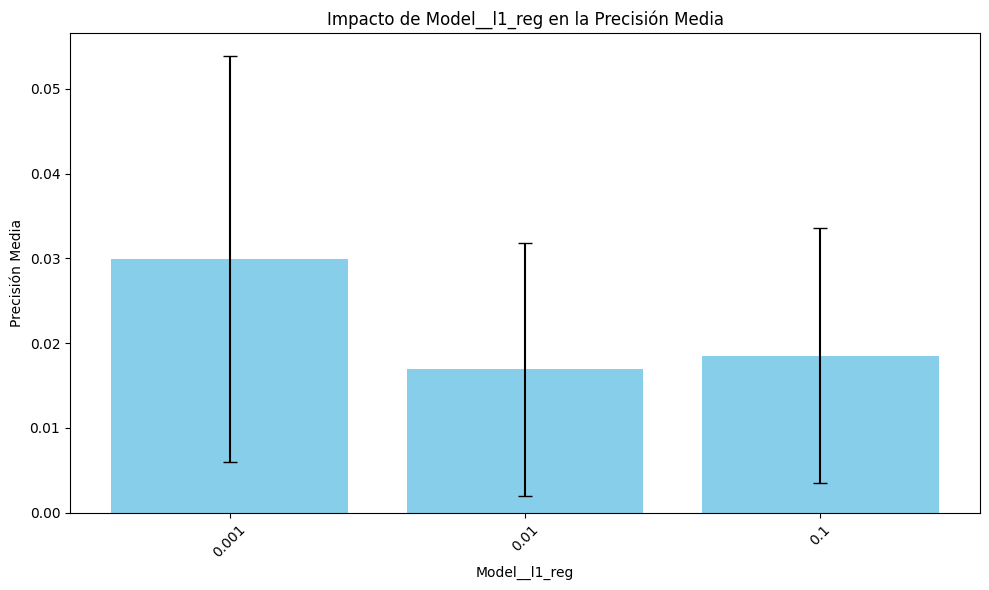

In [21]:
# Selecciona el hiperparámetro para visualizar
hyperparam = 'model__l1_reg'  # Este es el hiperparámetro de interés

# Preparando los datos para el gráfico
# Agrupando por el hiperparámetro seleccionado y calculando la media y desviación estándar de la precisión para cada valor
grouped = results_df.groupby(hyperparam)['Test mean Accuracy'].agg(['mean', 'std']).reset_index()

# Crear un rango de índices para las etiquetas de categorías
x_labels = range(len(grouped[hyperparam]))

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.bar(x_labels, grouped['mean'], yerr=grouped['std'], color='skyblue', capsize=5)
plt.title(f'Impacto de {hyperparam.capitalize()} en la Precisión Media')
plt.xlabel(hyperparam.capitalize())
plt.ylabel('Precisión Media')

# Asignar etiquetas de categorías al eje x
plt.xticks(x_labels, grouped[hyperparam], rotation=45)

plt.tight_layout()
plt.show()


### 6. Conclusión

En este laboratorio, aplicamos técnicas de optimización de hiperparámetros en un modelo de red neuronal convolucional (CNN) para clasificar imágenes del conjunto de datos CIFAR-10. A través del uso de GridSearchCV con KerasClassifier, exploramos combinaciones de hiperparámetros críticos, incluyendo la tasa de aprendizaje, el tamaño de lote, el optimizador y la función de pérdida, buscando la configuración óptima que maximizara la precisión de nuestro modelo.

Los resultados obtenidos demuestran que la optimización de hiperparámetros juega un papel crucial en el desempeño de los modelos de aprendizaje profundo. Identificamos la combinación de hiperparámetros que proporcionó la mayor precisión en la clasificación de las imágenes CIFAR-10, lo cual subraya la importancia de un proceso de selección y ajuste meticuloso.

Este laboratorio también destaca la potencia y flexibilidad de scikeras y GridSearchCV para integrar modelos de Keras en flujos de trabajo de aprendizaje automático con scikit-learn, facilitando así la experimentación y la optimización de modelos de aprendizaje profundo.

---
## Gracias por completar este laboratorio!